# Library

In [1]:
from tqdm import tqdm
from Module.Global_variable import os, time, torch, np, pd, plt
from Module.utils.Convenience_Function_by_torch import torch_device
from Module.utils.Convenience_Function import draw_img_and_bbox_torch_style

from Module.inference.inference_one_img import inference
from Module.inference.evaluate_trained_model import model_performance_check
from Module.inference.process_code import get_evaluate_dataset, get_model, get_img_info_df, get_info_df_img

# Global Variable

In [2]:
MODEL_PERFORMANCE_CHECK = False

parameter_path = f"Model/BackUp/retinaNet_resnet50_v2_AdamW_best_model.pt"
model_key = 'retinaNet'
cnn_key = 'resnet50_v2'
gpu_num = 0
k = 0
batch_size = 8

device = torch_device().get_device(gpu_number=gpu_num)

# Process

In [3]:
%%time

# 평가를 위한 데이터를 가지고 온다.
valid_label_dict, test_label_dict = get_evaluate_dataset(k)

# 학습이 끝난 모델을 가지고 온다.
trained_model = get_model(model_key, cnn_key, parameter_path, class_num=2, device=device)
inference_Ins = inference(model=trained_model, device=device)

# 모델의 성능평가.
if MODEL_PERFORMANCE_CHECK:
    print("model performance check")
    model_performance_check(
        model=trained_model,
        valid_dict=valid_label_dict,
        test_dict=test_label_dict,
        batch_size=batch_size,
        device=device
    ).process()
    
# test set의 image와 label의 정보들을 가지고 온다.
test_img_info_df = get_img_info_df(label_dict=test_label_dict)

CPU times: user 10.6 s, sys: 1.53 s, total: 12.1 s
Wall time: 4.4 s


In [4]:
test_img_info_df[test_img_info_df["bbox"] == "True"]

,file_name,height,width,id,bbox,area,box_size
1,A0003_00020_P_N_A.jpg,480,640,21,True,307200,4
3,A0005_00032_T_C_B.jpg,480,640,33,True,307200,4
4,A0007_00040_T_C_B.jpg,480,640,41,True,307200,4
5,A0007_00044_P_N_A.jpg,480,640,45,True,307200,4
76,A0066_00394_T_C_B.jpg,480,640,395,True,307200,4
...,...,...,...,...,...,...,...
2442,E1014_12234_O_N_B.jpg,1080,1920,12235,True,2073600,8
2443,E1016_12238_B_B_B.jpg,1024,1280,12239,True,1310720,9
2444,E1017_12239_O_N_B.jpg,480,640,12240,True,307200,8
2445,E1018_12240_T_N_B.jpg,1080,1920,12241,True,2073600,18


# 한 이미지에 대한 추론

In [5]:
img = get_info_df_img(info_df=test_img_info_df, idx=2445)

In [6]:
%%time
predict = inference_Ins(img)

CPU times: user 7.83 s, sys: 679 ms, total: 8.51 s
Wall time: 1.19 s


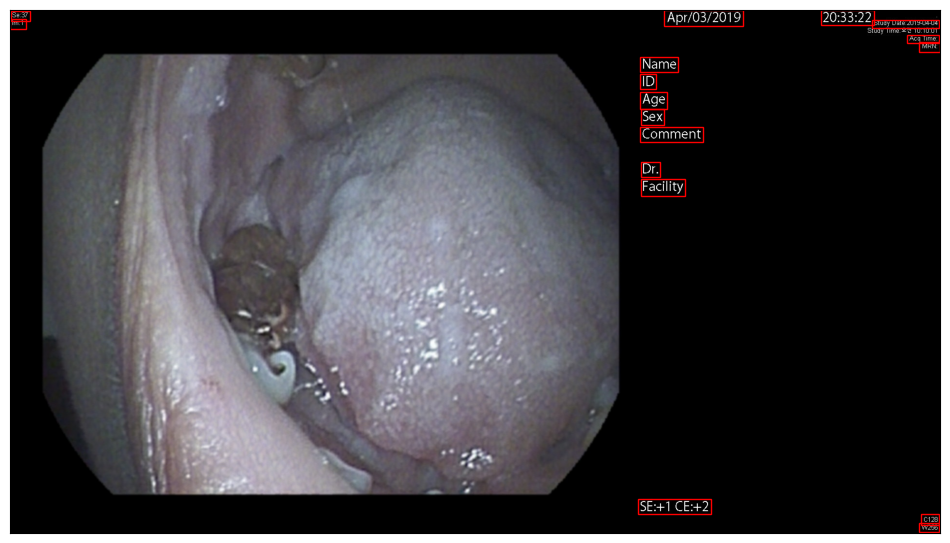

In [7]:
draw_img_and_bbox_torch_style(img, bbox_list=predict['boxes'])

In [8]:
target_df = test_img_info_df[test_img_info_df["bbox"] == "True"].reset_index(drop=True)

stack_list = []
for idx in tqdm(target_df.index):
    
    img = get_info_df_img(info_df=target_df, idx=idx)
    start = time.time()
    predict = inference_Ins(img)
    stack_list.append(time.time() - start)
    
target_df["time"] = stack_list

100%|██████████| 820/820 [00:48<00:00, 16.97it/s]


In [9]:
target_df['time'][1:].mean()

0.045745954117641055

## 최종 성능 평가
* 이미지 820장을 대상으로 했을 때, 장당 0.046초 소모.
* VRAM 1896MB 사용.

In [14]:
img_size_Sr = target_df['height'].astype('str') + "x" + target_df['width'].astype('str')

In [16]:
img_size_Sr.value_counts()

1080x1920    176
480x640      174
452x936      166
424x616      106
1024x1280     97
849x1232      28
452x468       27
424x308       20
905x1872       7
1800x2880      4
1080x1440      2
774x1039       1
731x926        1
412x616        1
810x1058       1
830x997        1
836x1087       1
827x1007       1
818x1038       1
793x1101       1
811x1054       1
821x1065       1
1072x1920      1
833x1053       1
Name: count, dtype: int64

In [19]:
np.sqrt(target_df['area'].mean())

942.4444423037722